In [1]:
import pandas as pd
from scipy.io import mmread
import scanpy as sc
import os
import sys
sys.path.append(os.path.abspath('../../'))
import SortedNoDupeBedOverlap as bdO
import annotate_sc_atac


In [2]:
mat = mmread('filtered_peak_bc_matrix/matrix.mtx')

In [3]:
mat = mat.toarray()

In [4]:
id2bc = pd.read_csv('filtered_peak_bc_matrix/barcodes.tsv', header = None)[0].values
id2peak = bdO.BedScan('filtered_peak_bc_matrix/peaks.bed')

In [5]:
df_peak = pd.read_csv('filtered_peak_bc_matrix/peaks.bed', header = None, sep = '\t')

In [6]:
len(id2peak)

84626

In [7]:
data_obj = sc.AnnData(mat.T, 
          obs = pd.DataFrame([], index = id2bc),
          var = df_peak,
          )

/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
sc.pp.normalize_total(data_obj)
sc.pp.pca(data_obj, n_comps=50)
sc.pp.neighbors(data_obj)
sc.tl.umap(data_obj)

/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 0 as categorical


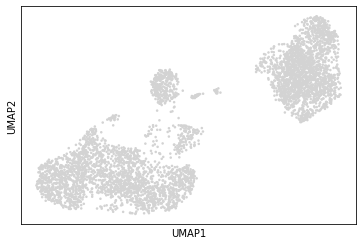

In [9]:
sc.pl.umap(data_obj)

In [13]:
#ref_subtype_peaks, ref_bk_peak = annotate_sc_atac.read_reference_data('../../data/GSE129785/', verbose = False)
ref_subtype_peaks, ref_bk_peak = annotate_sc_atac.read_reference_data('../../data/cistopic/', verbose = False)

In [14]:
intersect = bdO.BedOverlap(id2peak, ref_bk_peak, 50)

set2_ref = []
for i, (ct, peaks) in enumerate(ref_subtype_peaks):
    peaks_intersect = bdO.BedOverlap(id2peak, peaks, 50)
    ref_subtype_peaks[i] = (ct, peaks_intersect)

In [13]:
tmp = set(['Basophil',
 'Central memory CD8 T',
 'Effector memory CD8 T',
 'Mature NK1',
 'Memory B',
 'Memory CD4 T',
 'Monocyte 1',
 'Naive B',
 'cDC',
 'pDC'])
ref_subtype_peaks = [item for item in ref_subtype_peaks if item[0] in tmp]

In [15]:
for c, peaks in ref_subtype_peaks:
    print(c, len(peaks))

Bcell 14834
CD34-Bone-Marrow 15297
CD34-Cord-Blood 15397
CD4Tcell 18152
CD8Tcell 20006
Mono 16264
NKcell 18130


In [16]:
mat.shape, len(id2peak)

((84626, 4654), 84626)

In [ ]:
scores = annotate_sc_atac.compute_enrichment_score(mat, intersect, id2peak, ref_subtype_peaks, num_cores = 1)

In [ ]:
score_df = pd.DataFrame(scores, 
                        columns = [c for c, _ in ref_subtype_peaks],
                       index = data_obj.obs.index
                       )

In [ ]:
score_df.head()

In [ ]:
data_obj.obs = score_df

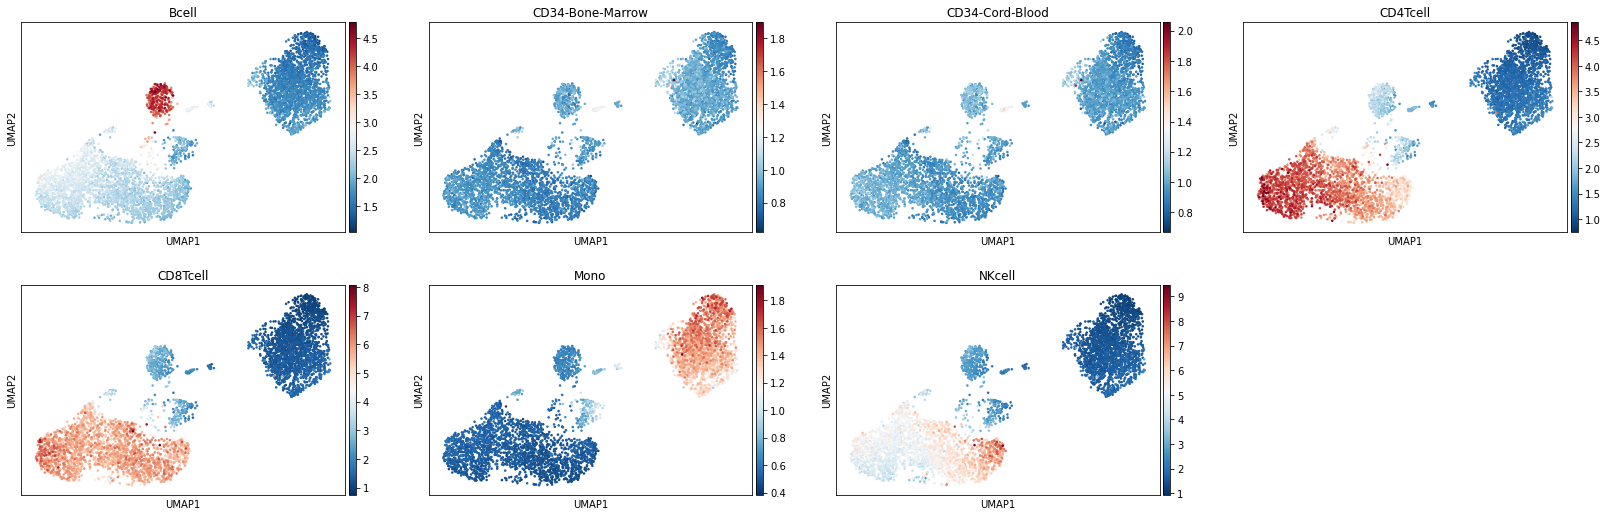

In [21]:
sc.pl.umap(data_obj, color = score_df.columns, cmap = 'RdBu_r')